In [1]:
# module for better path handeling
from pathlib import Path
# module for nn
import tensorflow as tf
# module for some numericals
import numpy as np
# module to work with large datasets
import pandas as pd
# module for graphical output and the widget magic
import matplotlib.pyplot as plt
# to clear the screen if wanted
import IPython
import IPython.display

# Data Import

In [2]:
data_path = Path("kiel_air_quality_tensorflow/datasets/all.csv")
# data_path = Path
df = pd.read_csv(data_path)
print(list(df))
df = df[['NO2-ug-per-m3', 'YearSin', 'YearSin', 'MonthSin', 'MonthCos', 'WeekSin', 'WeekCos', 'DaySin', 'DayCos', 'Cars-Direction-1', 'Cars-Direction-2', 'Cars-Total', 'did_it_rain', 'rain_millimeters', 'SchoolHoliday', 'wind_meters_per_second', 'relative_humidity_percent', 'e5', 'e10', 'diesel', 'Number of vessels', ]]
print(df.dtypes)
print(df.head())

['NO2-ug-per-m3', 'Cars-Direction-1', 'Cars-Direction-2', 'Cars-Total', 'Day-Of-Week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'SchoolHoliday', 'wind_meters_per_second', 'rain_millimeters', 'did_it_rain', 'air_temp_deg_c', 'relative_humidity_percent', 'e5', 'e10', 'diesel', 'Number of vessels', 'DateTime', 'DaySin', 'DayCos', 'WeekSin', 'WeekCos', 'MonthSin', 'MonthCos', 'YearSin', 'YearCos']
NO2-ug-per-m3                float64
YearSin                      float64
YearSin                      float64
MonthSin                     float64
MonthCos                     float64
WeekSin                      float64
WeekCos                      float64
DaySin                       float64
DayCos                       float64
Cars-Direction-1               int64
Cars-Direction-2               int64
Cars-Total                     int64


In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

# spliting the dataframe in three new ones
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# WindowGenerator Class

In [4]:
class WindowGenerator():
    # input_width: the window size
    # label_with: the size of the corresponding label 
    # shit: how much the label is shiftet (to the future)
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [5]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1
            )

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

The Plot method is able to plot the example windows passed to a passed tf model

In [6]:
def plot(self, model=None, plot_col='NO2-ug-per-m3', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label='Inputs',
            marker='.',
            zorder=-10
        )

        if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
              label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(
            self.label_indices,
            labels[n, :, label_col_index],
#             edgecolors='k',
            label='Labels',
            c='#2ca02c',
#             s=64,
        )
        
        if model is not None:
            predictions = model(inputs)
            plt.plot(
                self.label_indices,
                predictions[n, :, label_col_index],
#                 marker='X',
#                 edgecolors='k',
                label='Predictions',
                c='#ff7f0e',
#                 s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel('Hour in Week')

WindowGenerator.plot = plot

Method that makes a tensorflow dataset from the pandas Dataframe. It is usesing the [`tf.keras.utils.timeseries_dataset_from_array`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) function to "Creates a dataset of sliding windows over a timeseries provided as array"

In [7]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [8]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Compile and Fit
A funtion that makes it possible to easily compile and fit tf models.

In [9]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2, epochs=MAX_EPOCHS, do_callback=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,                   
        mode='min',
    )

    model.compile(
        loss = tf.losses.MeanSquaredError(),
        optimizer = tf.optimizers.Adam(),
        metrics = [tf.metrics.MeanAbsoluteError()],
    )
    
    if do_callback:
        callbacks = [early_stopping]
    else:
        callbacks = None
    
    history = model.fit(
        window.train,
        epochs = epochs,
        validation_data = window.val,              
        callbacks = callbacks,
    )
    
    return history

# Single Step - RNN Model 

In [10]:
val_performance = {}
performance = {}


Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [ 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88 

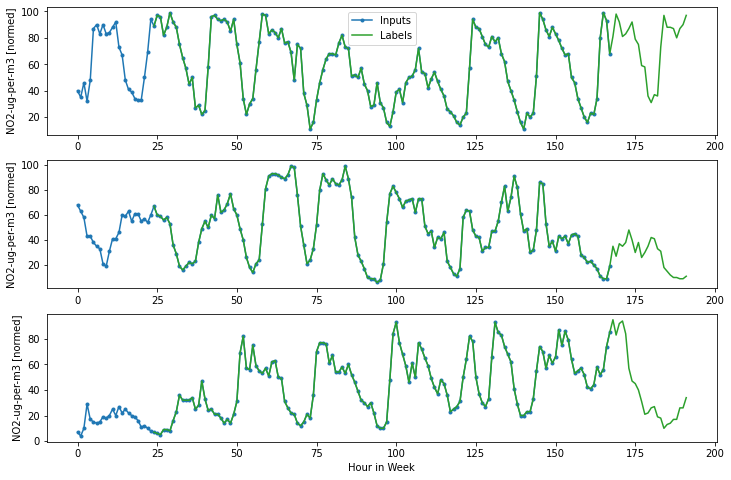

In [11]:
wide_window = WindowGenerator(
    input_width = 24*7, 
    label_width = 24*7, 
    shift = 24,
    label_columns = ['NO2-ug-per-m3'])

wide_window.plot()
wide_window

In [12]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Dropout(rate=.8),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.Dense(units=16),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [13]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 168, 21)
Output shape: (32, 168, 1)


In [14]:
# co
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
171/171 [==============================] - 10s 43ms/step - loss: 999.2212 - mean_absolute_error: 24.8981 - val_loss: 472.4772 - val_mean_absolute_error: 17.7736
Epoch 2/20
171/171 [==============================] - 7s 40ms/step - loss: 612.3701 - mean_absolute_error: 19.6621 - val_loss: 468.1756 - val_mean_absolute_error: 17.4950
Epoch 3/20
171/171 [==============================] - 7s 40ms/step - loss: 570.5992 - mean_absolute_error: 18.8996 - val_loss: 479.9268 - val_mean_absolute_error: 17.3440
Epoch 4/20
171/171 [==============================] - 7s 41ms/step - loss: 535.4376 - mean_absolute_error: 18.2539 - val_loss: 474.3529 - val_mean_absolute_error: 17.3070
Epoch 5/20
171/171 [==============================] - 7s 40ms/step - loss: 500.3102 - mean_absolute_error: 17.6041 - val_loss: 472.9306 - val_mean_absolute_error: 17.2979
Epoch 6/20
171/171 [==============================] - 7s 40ms/step - loss: 455.6866 - mean_absolute_error: 16.8051 - val_loss: 510.4999 - val_me

This plots shows the prediction for a hole week shifted a day into the future

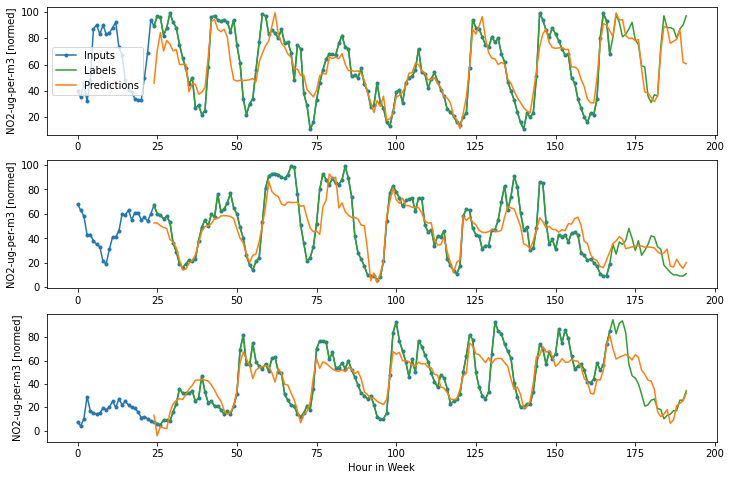

In [15]:
wide_window.plot(lstm_model)

# Multi Step 

## Creating the Window

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): None

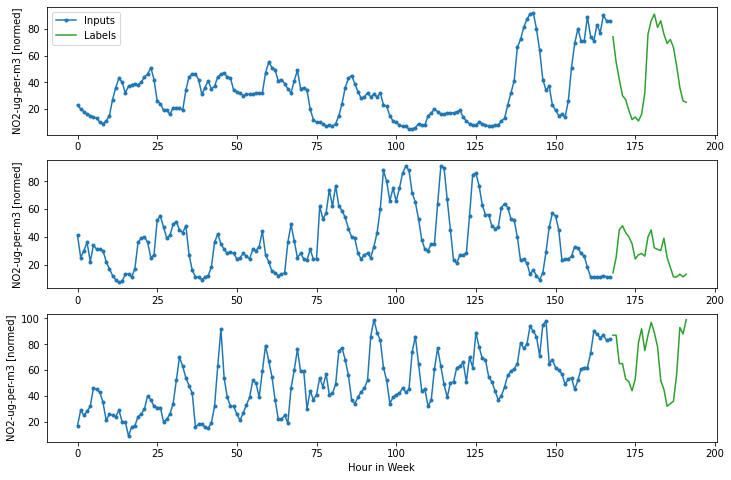

In [16]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width = 24*7,
   label_width = OUT_STEPS,
   shift = OUT_STEPS,
)

multi_window.plot()
multi_window

In [17]:
print('Input shape:', multi_window.example[0].shape)

Input shape: (32, 168, 21)


## Baselines

45/45 [==============================] - 0s 864us/step - loss: 28127.5020 - mean_absolute_error: 48.9356


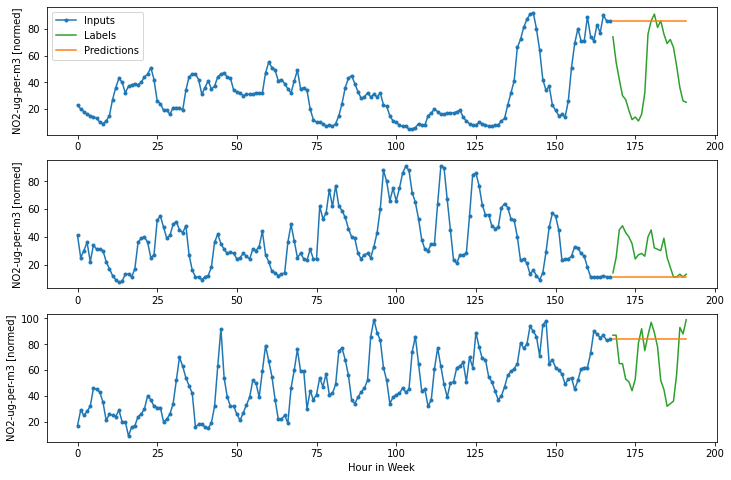

In [18]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


The bellow cell with the other Baseline is not working at the moment

In [19]:
# class RepeatBaseline(tf.keras.Model):
#     def call(self, inputs):
#         return inputs

# repeat_baseline = RepeatBaseline()
# repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
#                         metrics=[tf.metrics.MeanAbsoluteError()])

# multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
# multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(repeat_baseline)

## Simple - Dense Model

Epoch 1/20
171/171 [==============================] - 1s 4ms/step - loss: 18176.6426 - mean_absolute_error: 40.8618 - val_loss: 10448.6367 - val_mean_absolute_error: 32.5668
Epoch 2/20
171/171 [==============================] - 1s 3ms/step - loss: 10977.3535 - mean_absolute_error: 32.3832 - val_loss: 8956.7637 - val_mean_absolute_error: 29.2557
Epoch 3/20
171/171 [==============================] - 1s 3ms/step - loss: 9907.4414 - mean_absolute_error: 30.3727 - val_loss: 8359.4570 - val_mean_absolute_error: 28.2107
Epoch 4/20
171/171 [==============================] - 1s 3ms/step - loss: 9432.1250 - mean_absolute_error: 29.3830 - val_loss: 8030.6211 - val_mean_absolute_error: 27.0248
Epoch 5/20
171/171 [==============================] - 1s 3ms/step - loss: 9195.9443 - mean_absolute_error: 28.8277 - val_loss: 7913.7979 - val_mean_absolute_error: 26.9459
Epoch 6/20
171/171 [==============================] - 1s 3ms/step - loss: 8902.9277 - mean_absolute_error: 28.1491 - val_loss: 7790.8384 

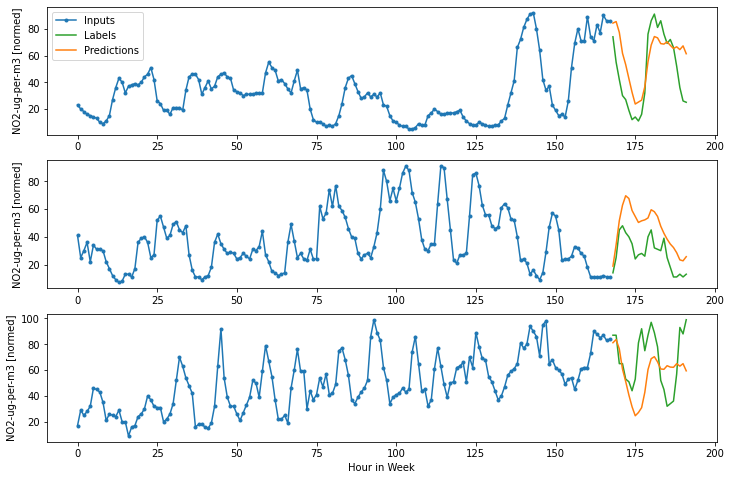

In [20]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## Simple - RNN

Epoch 1/20
171/171 [==============================] - 9s 41ms/step - loss: 28832.0801 - mean_absolute_error: 50.8882 - val_loss: 15043.3955 - val_mean_absolute_error: 42.0710
Epoch 2/20
171/171 [==============================] - 7s 38ms/step - loss: 16590.5586 - mean_absolute_error: 44.0543 - val_loss: 14943.1533 - val_mean_absolute_error: 42.2053
Epoch 3/20
171/171 [==============================] - 7s 38ms/step - loss: 16547.0859 - mean_absolute_error: 44.0268 - val_loss: 14918.9766 - val_mean_absolute_error: 42.0486
Epoch 4/20
171/171 [==============================] - 7s 40ms/step - loss: 16517.1699 - mean_absolute_error: 43.9737 - val_loss: 14897.5859 - val_mean_absolute_error: 42.0128
Epoch 5/20
171/171 [==============================] - 7s 39ms/step - loss: 16429.8496 - mean_absolute_error: 43.8397 - val_loss: 14826.1562 - val_mean_absolute_error: 41.9115
Epoch 6/20
171/171 [==============================] - 7s 39ms/step - loss: 16288.5322 - mean_absolute_error: 43.6024 - val_lo

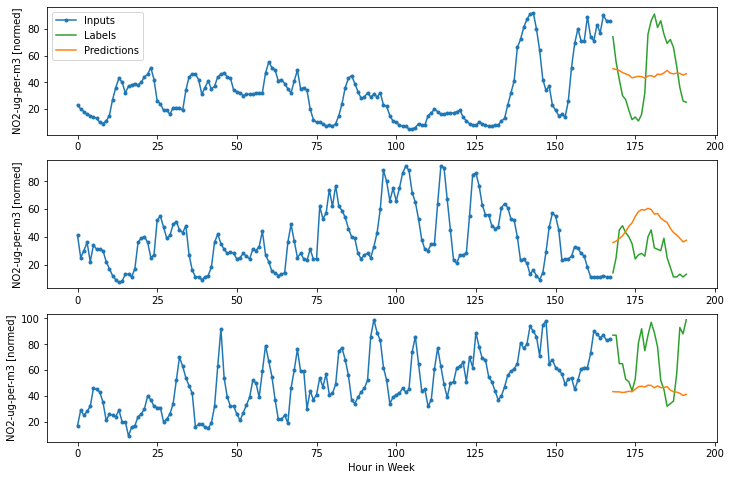

In [21]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(512, activation="relu"),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Simple - RNN with more epochs

Epoch 1/50
171/171 [==============================] - 9s 41ms/step - loss: 29378.7363 - mean_absolute_error: 51.3329 - val_loss: 15081.4219 - val_mean_absolute_error: 42.1148
Epoch 2/50
171/171 [==============================] - 7s 38ms/step - loss: 16568.4004 - mean_absolute_error: 44.0162 - val_loss: 14869.5547 - val_mean_absolute_error: 41.9525
Epoch 3/50
171/171 [==============================] - 7s 40ms/step - loss: 16470.4141 - mean_absolute_error: 43.9354 - val_loss: 14850.9727 - val_mean_absolute_error: 41.9210
Epoch 4/50
171/171 [==============================] - 7s 39ms/step - loss: 16364.0391 - mean_absolute_error: 43.7978 - val_loss: 14811.8730 - val_mean_absolute_error: 41.9351
Epoch 5/50
171/171 [==============================] - 7s 39ms/step - loss: 16298.9209 - mean_absolute_error: 43.6897 - val_loss: 14717.1055 - val_mean_absolute_error: 41.6821
Epoch 6/50
171/171 [==============================] - 7s 39ms/step - loss: 16236.6064 - mean_absolute_error: 43.5434 - val_lo

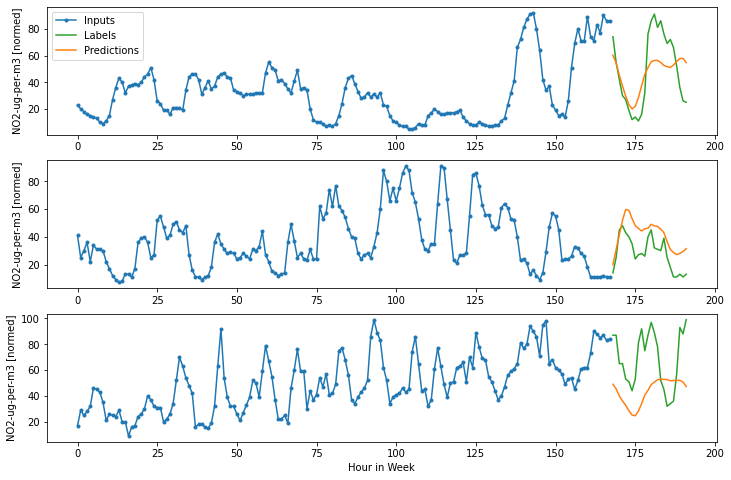

In [22]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(512, activation="relu"),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, epochs=50)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## "Complex" - RNN 

Epoch 1/40
171/171 [==============================] - 9s 44ms/step - loss: 21040.7402 - mean_absolute_error: 47.6213 - val_loss: 14911.7148 - val_mean_absolute_error: 42.1680
Epoch 2/40
171/171 [==============================] - 7s 42ms/step - loss: 16512.1230 - mean_absolute_error: 43.9506 - val_loss: 14726.5205 - val_mean_absolute_error: 41.9603
Epoch 3/40
171/171 [==============================] - 7s 42ms/step - loss: 16450.1328 - mean_absolute_error: 43.8647 - val_loss: 15121.2656 - val_mean_absolute_error: 42.0002
Epoch 4/40
171/171 [==============================] - 7s 42ms/step - loss: 16047.7939 - mean_absolute_error: 43.2392 - val_loss: 12380.6201 - val_mean_absolute_error: 37.4167
Epoch 5/40
171/171 [==============================] - 7s 43ms/step - loss: 12334.4805 - mean_absolute_error: 35.3037 - val_loss: 10919.1328 - val_mean_absolute_error: 33.1610
Epoch 6/40
171/171 [==============================] - 7s 42ms/step - loss: 11905.6855 - mean_absolute_error: 34.3594 - val_lo

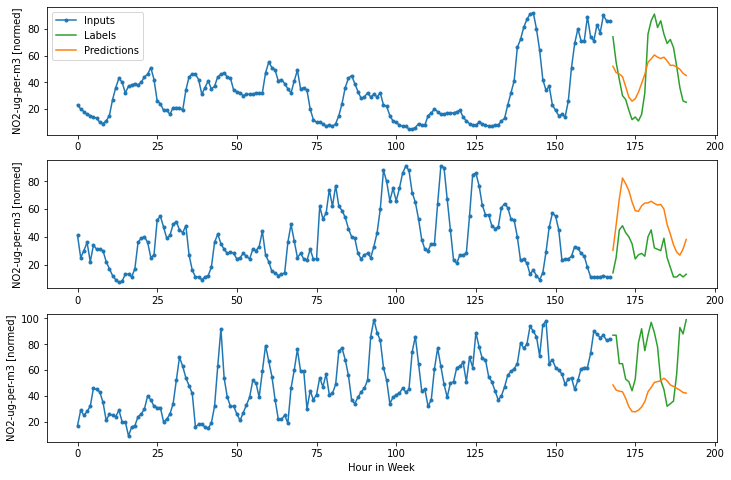

In [23]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(rate=.8),
    tf.keras.layers.Dense(512, activation="relu"),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, epochs=40)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)